**Load the data from the file**

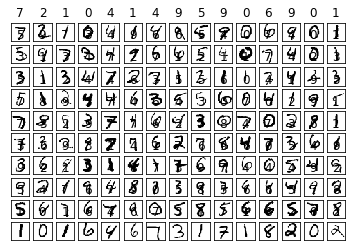

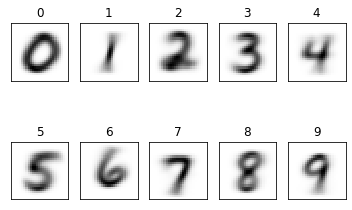

In [1]:
import numpy as np
import matplotlib.pyplot as plt

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()
size_row    = 28    # height of the image
size_col    = 28    # width of the image
num_image   = len(data)
count       = 0     # count for the number of images
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)
for line in data:
  line_data   = line.split(',')
  label       = line_data[0]
  im_vector   = np.asfarray(line_data[1:])    
  list_label[count]       = label
  list_image[:, count]    = im_vector
  count += 1

f1 = plt.figure(1)
for i in range(150):
  label       = list_label[i]
  im_vector   = list_image[:, i]
  im_matrix   = im_vector.reshape((size_row, size_col))
  plt.subplot(10, 15, i+1)
  plt.title(label)
  plt.imshow(im_matrix, cmap='Greys', interpolation='None')
  frame   = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)

f2 = plt.figure(2)
im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)
for i in range(num_image):
  im_average[:, list_label[i]] += list_image[:, i]
  im_count[list_label[i]] += 1

for i in range(10):
  im_average[:, i] /= im_count[i]
  plt.subplot(2, 5, i+1)
  plt.title(i)
  plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')
  frame   = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
plt.show()

**Main process**

In [43]:
# Devide testing and training sets
train_imgs = np.empty((6000, size_row * size_col), dtype=float)
test_imgs = np.empty((4000, size_row * size_col), dtype=float)
train_labels = np.empty(6000, dtype=int)
test_labels = np.empty(4000, dtype=int)
for i in range(num_image):
  if i < 6000:
    train_labels[i] = list_label[i]
    train_imgs[i] = list_image[:, i]
  else:
    test_labels[i-6000] = list_label[i]
    test_imgs[i-6000] = list_image[:, i]


# normalization
fac = 0.99 / 255
train_imgs = np.asfarray(train_imgs) * fac + 0.01
test_imgs = np.asfarray(test_imgs) * fac + 0.01
train_labels = np.asfarray(train_labels)
test_labels = np.asfarray(test_labels)

# One hot encoding our labels
train_targets = np.array(train_labels).astype(np.int)
train_labels_one_hot = np.eye(np.max(train_targets) + 1)[train_targets]
test_targets = np.array(test_labels).astype(np.int)
test_labels_one_hot = np.eye(np.max(test_targets) + 1)[test_targets]

train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99

def sigmoid(z):
  return 1 / ( 1 + np.exp(-z))

class NeuralNetwork:
  def __init__(self):
    self.lr = 0.01
    self.w1 = np.random.randn(784, 196)
    self.b1 = np.zeros((1, 196))  
    self.w2 = np.random.randn(196, 49)
    self.b2 = np.zeros((1, 49))  
    self.w3 = np.random.randn(49, 10)
    self.b3 = np.zeros((1, 10))

  def feedforward(self):
    z1 = np.dot(self.x, self.w1) + self.b1
    self.a1 = sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    self.a2 = sigmoid(z2)
    z3 = np.dot(self.a2, self.w3) + self.b3
    self.a3 = sigmoid(z3)      

  def compute_cost(self, y_pred, y):
    m = y.shape[1]
    #loss = - np.sum(np.multiply(y, np.log(y_pred)))
    #print(loss)
    #cost = loss / m
    #cost = np.squeeze(cost)      
    cost = np.mean(np.sum(-y*np.log(y_pred), axis=1))
    return cost

  def backprop(self):        
    output_errors = self.y - self.a3        
    a3_delta = output_errors * (self.a3 * (1.0 - self.a3)) # w3        
    z2_delta = np.dot(output_errors, self.w3.T)
    a2_delta = z2_delta * (self.a2 * (1.0 - self.a2)) # w2        
    z1_delta = np.dot(z2_delta, self.w2.T)
    a1_delta = z1_delta * (self.a1 * (1.0 - self.a1)) # w1

    self.w3 += self.lr * np.dot(self.a2.T, a3_delta)
    self.b3 += self.lr * np.sum(a3_delta, axis=0, keepdims=True)        
    self.w2 += self.lr * np.dot(self.a1.T, a2_delta)
    self.b2 += self.lr * np.sum(a2_delta, axis=0, keepdims=True)        
    self.w1 += self.lr * np.dot(self.x.T, a1_delta)
    self.b1 += self.lr * np.sum(a1_delta, axis=0, keepdims=True)    
    
  def train(self, x, y):
    self.x = np.array(x, ndmin=2)
    self.y = np.array(y, ndmin=2)
    self.feedforward()
    self.backprop()

  def predict(self, data):
    self.x = np.array(data, ndmin=2)
    self.feedforward()
    return self.a3

  def evaluate(self, x, y):
    corrects, wrongs = 0, 0
    for i in range(len(x)):
      res = self.predict(x[i])
      res_max = res.argmax()
      if res_max == y[i]:
        corrects += 1
      else:
        wrongs += 1
    return corrects, wrongs

model = NeuralNetwork()
epochs = 10
costs_train = []
costs_test = []
accuracys_train = []
accuracys_test = []

for epoch in range(epochs):
  print("epoch: ", epoch+1)
  for i in range(len(train_imgs)):
    model.train(train_imgs[i], train_labels_one_hot[i])  
  
  corrects, wrongs = model.evaluate(train_imgs, train_labels)  
  accuracys_train.append(corrects / ( corrects + wrongs))
  costs_train.append(model.compute_cost(model.predict(train_imgs), train_labels_one_hot))   
  # print("accruracy train: ", corrects / ( corrects + wrongs))  
  corrects, wrongs = model.evaluate(test_imgs, test_labels)
  # print("accruracy test :", corrects / ( corrects + wrongs))
  accuracys_test.append(corrects / ( corrects + wrongs))
  costs_test.append(model.compute_cost(model.predict(test_imgs), test_labels_one_hot))
  
  

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10


**Plot the loss curve**

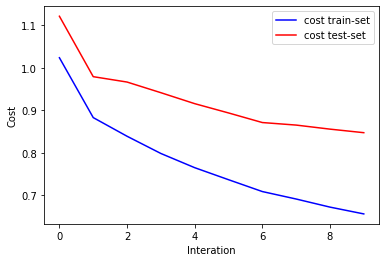

In [44]:
plt.plot(costs_train, c='b', label='cost train-set')
plt.plot(costs_test, c='r', label='cost test-set')
plt.xlabel("Interation")
plt.ylabel("Cost")
plt.legend()
plt.show()

**Plot the accuracy curve**

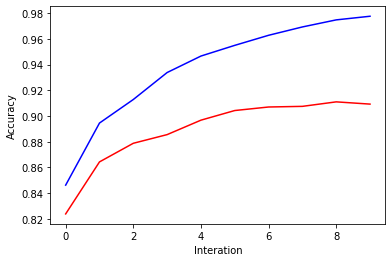

In [45]:
plt.plot(accuracys_train, c='b', label='accuracy train-set')
plt.plot(accuracys_test, c='r', label='accuracy test-set')
plt.xlabel("Interation")
plt.ylabel("Accuracy")
plt.show()

**Plot final accuracy**

In [46]:
print('Final training accuracy: ',accuracys_train[9]*100, '%')
print('Final testing accuracy: ',accuracys_test[9]*100, '%')

Final training accuracy:  97.76666666666667 %
Final testing accuracy:  90.925 %


**Plot the classification example**